In [0]:
# Your code goes in here
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
spark_df = sqlContext.sql("Select * from marketingcampaign_2_csv")

/databricks/spark/python/pyspark/sql/context.py:82: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.functions import *

responselabel = udf(lambda x: 1 if x == 'Yes' else 0, IntegerType())
spark_df = spark_df.withColumn("Response", responselabel(spark_df["Response"])) #creates a new column class label
spark_df.select('Response').show()

+--------+
|Response|
+--------+
|       0|
|       0|
|       0|
|       0|
|       0|
|       1|
|       1|
|       0|
|       1|
|       0|
|       0|
|       0|
|       0|
|       1|
|       0|
|       0|
|       0|
|       0|
|       0|
|       0|
+--------+
only showing top 20 rows



In [0]:
spark_df = spark_df.drop(spark_df.Customer)

In [0]:
spark_df.show()

+----------+-----------------------+--------+--------------------+-----------------+----------------+------+------+-------------+--------------+--------------------+-----------------------+------------------+--------------+------------+----------------+-------------+------------------+-------------+------------+--------+
|     State|Customer Lifetime Value|Coverage|           Education|Effective To Date|EmploymentStatus|Gender|Income|Location Code|Marital Status|Monthly Premium Auto|Months Since Last Claim|Number of Policies|   Policy Type|      Policy|Renew Offer Type|Sales Channel|Total Claim Amount|Vehicle Class|Vehicle Size|Response|
+----------+-----------------------+--------+--------------------+-----------------+----------------+------+------+-------------+--------------+--------------------+-----------------------+------------------+--------------+------------+----------------+-------------+------------------+-------------+------------+--------+
|Washington|              2763.

In [0]:
display(spark_df.describe())

summary,State,Customer Lifetime Value,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Response
count,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134,9134
mean,null,8004.94046709442,null,null,null,null,null,37657.38000875848,null,null,93.21929056273265,15.097000218962119,2.9661703525290126,null,null,null,null,434.0887943282862,null,null,0.14320122618786948
stddev,null,6870.967590289856,null,null,null,null,null,30379.904733846317,null,null,34.407967371786505,10.073256571394245,2.3901818097011316,null,null,null,null,290.5000924450248,null,null,0.35029711562560917
min,Arizona,1898.0077,Basic,Bachelor,1/1/2011,Disabled,F,0,Rural,Divorced,61,0,1,Corporate Auto,Corporate L1,Offer1,Agent,0.099007,Four-Door Car,Large,0
max,Washington,83325.38,Premium,Master,2/9/2011,Unemployed,M,99981,Urban,Single,298,35,9,Special Auto,Special L3,Offer4,Web,2893.2397,Two-Door Car,Small,1


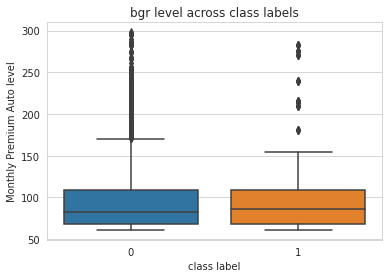

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots()
sns.set_style("whitegrid")

pandas_df = spark_df.select('Monthly Premium Auto', 'Response').toPandas()

ax = sns.boxplot(x='Response', y='Monthly Premium Auto', data = pandas_df)

ax.set_title('bgr level across class labels')
ax.set(xlabel='class label', ylabel='Monthly Premium Auto level')

plt.show()

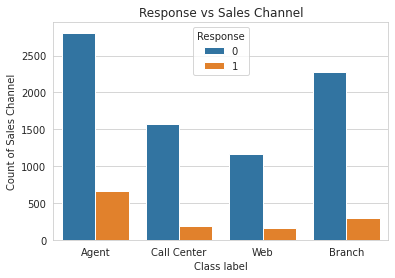

In [0]:
fig, ax = plt.subplots()
sns.set_style("whitegrid")

pandas_df = spark_df.select('Sales Channel', 'Response').toPandas()
g = sns.countplot(
    data=pandas_df,
    hue="Response", x="Sales Channel",
)
ax.set_title('Response vs Sales Channel')
ax.set(xlabel='Class label', ylabel='Count of Sales Channel')

plt.show()

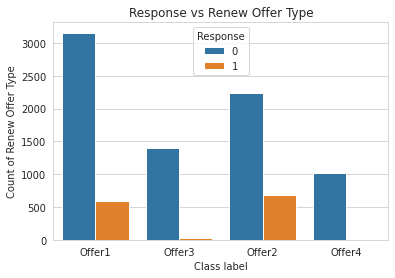

In [0]:
fig, ax = plt.subplots()
sns.set_style("whitegrid")

pandas_df = spark_df.select('Renew Offer Type', 'Response').toPandas()
g = sns.countplot(
    data=pandas_df,
    hue="Response", x="Renew Offer Type",
)
ax.set_title('Response vs Renew Offer Type')
ax.set(xlabel='Class label', ylabel='Count of Renew Offer Type')

plt.show()

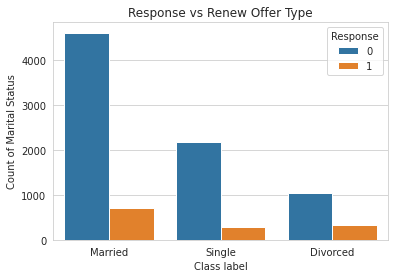

In [0]:
fig, ax = plt.subplots()
sns.set_style("whitegrid")

pandas_df = spark_df.select('Marital Status', 'Response').toPandas()
g = sns.countplot(
    data=pandas_df,
    hue="Response", x="Marital Status",
)
ax.set_title('Response vs Renew Offer Type')
ax.set(xlabel='Class label', ylabel='Count of Marital Status')

plt.show()

In [0]:
target = 'Response'

In [0]:
dtypes = spark_df.dtypes
cat_input = []
for i in range(0, len(spark_df.columns)):
  if dtypes[i][1] == 'string': #identify categorical variable
    cat_input.append(dtypes[i][0]) 
cat_input = list(set(cat_input)-set(target)) 
cat_input

Out[8]: ['State',
 'Education',
 'Policy Type',
 'EmploymentStatus',
 'Coverage',
 'Location Code',
 'Policy',
 'Marital Status',
 'Renew Offer Type',
 'Gender',
 'Vehicle Class',
 'Vehicle Size',
 'Sales Channel',
 'Effective To Date']

In [0]:
num_input = list(set(spark_df.columns) - set([target]) - set(cat_input))
num_input

Out[9]: ['Income',
 'Monthly Premium Auto',
 'Total Claim Amount',
 'Customer Lifetime Value',
 'Number of Policies',
 'Months Since Last Claim']

In [0]:
from pyspark import keyword_only  ## < 2.0 -> pyspark.ml.util.keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType


class Standardizer(Transformer, HasInputCol, HasOutputCol):

    def __init__(self, inputCol=None, outputCol=None):
        super(Standardizer, self).__init__()
        self.setParams(inputCol = inputCol , outputCol = outputCol)

        
        
    def setParams(self, inputCol=None, outputCol=None):
      return self._set(inputCol = inputCol, outputCol = outputCol)
        

    def _transform(self, dataset):
      from pyspark.sql.functions import stddev, mean, col
      out_col = self.getOutputCol()
      in_col = dataset[self.getInputCol()]
      xmin, xmax = dataset.select(min(in_col), max(in_col)).first()
      return dataset.withColumn(out_col, (in_col - xmin)/(xmax-xmin))

In [0]:
standardizers = [Standardizer(inputCol = column, outputCol = column+"_standardized") for column in num_input]
standardizers

Out[11]: [Standardizer_9f8482ba3dc8,
 Standardizer_3a0d66138ca8,
 Standardizer_d054aedf994a,
 Standardizer_f0809d7a8ddf,
 Standardizer_cf502d4ab0b4,
 Standardizer_a4c7476b46aa]

In [0]:
from pyspark import keyword_only  
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol = column, outputCol = column+"_index") for column in cat_input]
encoders = [OneHotEncoder(inputCol = column+"_index", outputCol = column+"_dummy") for column in cat_input]

In [0]:
input_cols = []
for i in cat_input:
  input_cols.append(i+"_dummy")
for i in num_input:
  input_cols.append(i+"_standardized")
input_cols

Out[13]: ['State_dummy',
 'Education_dummy',
 'Policy Type_dummy',
 'EmploymentStatus_dummy',
 'Coverage_dummy',
 'Location Code_dummy',
 'Policy_dummy',
 'Marital Status_dummy',
 'Renew Offer Type_dummy',
 'Gender_dummy',
 'Vehicle Class_dummy',
 'Vehicle Size_dummy',
 'Sales Channel_dummy',
 'Effective To Date_dummy',
 'Income_standardized',
 'Monthly Premium Auto_standardized',
 'Total Claim Amount_standardized',
 'Customer Lifetime Value_standardized',
 'Number of Policies_standardized',
 'Months Since Last Claim_standardized']

In [0]:
from pyspark.ml.feature import StringIndexer
import functools 
import operator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

stages = []
assembler = VectorAssembler(inputCols= input_cols, outputCol="features") #conactenates all input variables and names as features [[0,1,0],30,20,40000]
stages = functools.reduce(operator.concat, [indexers, encoders, standardizers]) #indexers,  encoders, standardizers])
stages.append(assembler)
stages

Out[14]: [StringIndexer_1848dee78b70,
 StringIndexer_a704bc4a90de,
 StringIndexer_a71809ef64e7,
 StringIndexer_29c2db5c009a,
 StringIndexer_7ec180105b07,
 StringIndexer_e08ab05ab75b,
 StringIndexer_95dc9fc93732,
 StringIndexer_642822a03fc6,
 StringIndexer_9bb0dd97bad7,
 StringIndexer_2b332d3fc985,
 StringIndexer_d507cba50cfa,
 StringIndexer_6bf6e23dd46f,
 StringIndexer_16789851d0f2,
 StringIndexer_0e89b0d788ee,
 OneHotEncoder_4df097b50524,
 OneHotEncoder_a640e4c64492,
 OneHotEncoder_864913b12b51,
 OneHotEncoder_24bf3cbe7745,
 OneHotEncoder_3f66f22ed47b,
 OneHotEncoder_5b6f87f46717,
 OneHotEncoder_2b25ba461770,
 OneHotEncoder_b7a2b8ddc095,
 OneHotEncoder_05a4a6bde5f2,
 OneHotEncoder_2d6cde41318f,
 OneHotEncoder_ee22fa229be7,
 OneHotEncoder_877fd7b4a537,
 OneHotEncoder_0004dbce3477,
 OneHotEncoder_82ac5a01fcef,
 Standardizer_9f8482ba3dc8,
 Standardizer_3a0d66138ca8,
 Standardizer_d054aedf994a,
 Standardizer_f0809d7a8ddf,
 Standardizer_cf502d4ab0b4,
 Standardizer_a4c7476b46aa,
 VectorAsse

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=stages)
spark_df = pipeline.fit(spark_df).transform(spark_df)

In [0]:
train, test = spark_df.randomSplit([0.8, 0.2], seed = 2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7275
Test Dataset Count: 1859


In [0]:
lr = LogisticRegression(labelCol=target, featuresCol="features", maxIter=5)
logRegModel = lr.fit(train)

In [0]:
print("Coefficients: \n" + str(logRegModel.coefficientMatrix))
print("Intercept: " + str(logRegModel.interceptVector))

Coefficients: 
DenseMatrix([[ 7.00604190e-02,  1.13366655e-01, -2.84954036e-02,
               9.75238486e-02, -2.76282867e-01,  4.68429637e-02,
              -2.92296557e-01,  7.89635049e-02,  4.18116591e-02,
              -1.67033819e-01, -2.01527190e+00, -2.45741740e+00,
              -1.57828877e+00, -1.69393841e+00,  4.56090240e-02,
              -1.01587634e-01,  1.55721199e+00, -9.09604566e-02,
              -1.28494357e-01,  7.84744418e-02,  2.05787719e-01,
              -1.76223814e-01, -4.84694648e-02, -2.10062763e-01,
              -8.59077055e-02,  2.06104165e-01, -8.36481950e-01,
              -6.83975413e-01,  1.98691195e+00,  2.30735444e+00,
              -1.34955004e+00, -8.01150408e-02, -1.00682079e-01,
              -1.51524507e-01,  2.74924271e-01,  3.60065764e-01,
               5.67020658e-01, -3.52204091e-01, -9.71667684e-01,
               6.78785457e-01, -1.61034789e-01, -1.06794228e-01,
               4.87150385e-01,  5.08939989e-01,  5.51858750e-01,
          

In [0]:
## Performance check on training data

In [0]:
summary = logRegModel.summary
accuracy = summary.accuracy
falsePositiveRate = summary.weightedFalsePositiveRate
truePositiveRate = summary.weightedTruePositiveRate
fMeasure = summary.weightedFMeasure()
precision = summary.weightedPrecision
recall = summary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.8699656357388316
FPR: 0.6674190291986434
TPR: 0.8699656357388316
F-measure: 0.8435811212636076
Precision: 0.8452946817171676
Recall: 0.8699656357388316


/databricks/spark/python/pyspark/sql/context.py:134: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


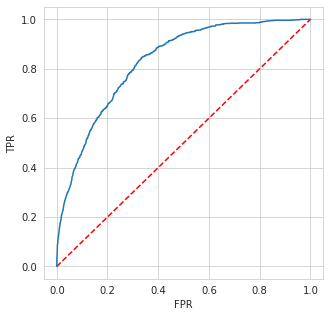

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(summary.roc.select('FPR').collect(),
         summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
display(plt.show())

In [0]:
predictions = logRegModel.transform(test)
predictions = predictions.withColumnRenamed("Response", "label")
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(5)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|    0|[6.57751143603600...|       0.0|[0.99861062569908...|
|    0|[2.41309041802621...|       0.0|[0.91782008210302...|
|    0|[1.15597732792365...|       0.0|[0.76060100613352...|
|    0|[4.55604744545427...|       0.0|[0.98960568398906...|
|    0|[2.76596894005036...|       0.0|[0.94080890532745...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8264955414529941
